### 1. Library Import

In [16]:
import pandas as pd
import re
import unicodedata 
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as STOP_FR
from spacy.lang.en.stop_words import STOP_WORDS as STOP_EN
from langdetect import detect

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt

import requests
import time

import threading

import os
import pickle
import numpy as np

from collections import defaultdict, Counter
import ast

from collections import Counter

import json
import matplotlib.pyplot as plt
import numpy as np
import ast
from collections import Counter



### 2. Data Import

In [3]:
df_filtered=pd.read_csv("CAIRN_LDA_FINAL2.csv")

In [20]:
display(df_filtered.head())

,url,Unnamed: 0,titre,auteur,section,twitter_card,journal,annee,numero,page_debut,...,any_author_in_chunk,author_present_in_article_x,author_present_in_article_y,author_present_in_article,chunk_clean,langue,tokens,topics_proportions_concat,top_2_topics_with_prop,top_4_topics_with_prop
0,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,False,True,True,True,l objectif de ce chapitre est d envisager à qu...,fr,"['objectif', 'chapitre', 'envisager', 'forme',...",topic_0:0.000 | topic_1:0.011 | topic_2:0.000 ...,"[(42, 0.328), (29, 0.201)]","[(42, 0.328), (29, 0.201), (48, 0.192), (55, 0..."
1,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,False,True,True,True,elle dépend d autre part de l identité de j do...,fr,"['dépendre', 'part', 'identité', 'donner', 'id...",topic_0:0.000 | topic_1:0.000 | topic_2:0.000 ...,"[(42, 0.232), (29, 0.128)]","[(42, 0.232), (29, 0.128), (48, 0.122), (44, 0..."
2,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,True,True,True,True,la politique inverse est alors envisageable à ...,fr,"['politique', 'inverse', 'envisageable', 'savo...",topic_0:0.000 | topic_1:0.000 | topic_2:0.000 ...,"[(44, 0.153), (29, 0.153)]","[(44, 0.153), (29, 0.153), (8, 0.125), (42, 0...."
3,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,False,True,True,True,ils sont supposés maximiser leur utilité de ma...,fr,"['supposer', 'maximiser', 'utilité', 'manière'...",topic_0:0.000 | topic_1:0.007 | topic_2:0.000 ...,"[(44, 0.327), (8, 0.157)]","[(44, 0.327), (8, 0.157), (48, 0.149), (29, 0...."
4,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,False,True,True,True,un décalage entre les actions présentes et leu...,fr,"['décalage', 'entrer', 'action', 'présenter', ...",topic_0:0.000 | topic_1:0.000 | topic_2:0.000 ...,"[(48, 0.217), (44, 0.193)]","[(48, 0.217), (44, 0.193), (29, 0.173), (9, 0...."


### 3. Data manipulation

The following code integrates the most important word of each topic in their "names".

In [21]:
# ---------------------------------------------------------------------------
# CONVERT STRING COLUMN TO LIST OF TUPLES
# ---------------------------------------------------------------------------

df_filtered["top_2_topics_with_prop"] = df_filtered[
    "top_2_topics_with_prop"
].apply(ast.literal_eval)

# Vérification
print("Type après conversion :")
print(df_filtered["top_2_topics_with_prop"].apply(type).value_counts())

# ---------------------------------------------------------------------------
# LOAD TOPIC → MAIN WORD
# ---------------------------------------------------------------------------

with open("topics_data.json", "r", encoding="utf-8") as f:
    topics_data = json.load(f)

topic_main_word = {
    int(topic_id): words[0][0]
    for topic_id, words in topics_data.items()
}

# ---------------------------------------------------------------------------
# ANNOTATE topics_proportions_concat
# ---------------------------------------------------------------------------

def annotate_topics_proportions_concat(s):
    if not isinstance(s, str):
        return s

    parts = s.split(" | ")
    annotated_parts = []

    for part in parts:
        match = re.match(r"topic_(\d+):([\d\.]+)", part)
        if match:
            topic_id = int(match.group(1))
            prop = match.group(2)
            word = topic_main_word.get(topic_id, "NA")
            annotated_parts.append(f"topic_{topic_id} ({word}):{prop}")
        else:
            annotated_parts.append(part)

    return " | ".join(annotated_parts)


df_filtered["topics_proportions_concat"] = df_filtered[
    "topics_proportions_concat"
].apply(annotate_topics_proportions_concat)

# ---------------------------------------------------------------------------
# ANNOTATE top_2_topics_with_prop
# ---------------------------------------------------------------------------

def annotate_top_2_topics_with_prop(topics):
    annotated = []
    for topic_id, prop in topics:
        word = topic_main_word.get(int(topic_id), "NA")
        annotated.append((f"topic_{topic_id} ({word})", round(float(prop), 3)))
    return annotated


df_filtered["top_2_topics_with_prop"] = df_filtered[
    "top_2_topics_with_prop"
].apply(annotate_top_2_topics_with_prop)

# ---------------------------------------------------------------------------
# OPTIONAL: STRING VERSION FOR CSV / READABILITY
# ---------------------------------------------------------------------------

df_filtered["top_2_topics_with_prop_str"] = df_filtered[
    "top_2_topics_with_prop"
].apply(lambda topics: " | ".join(f"{t}:{p:.3f}" for t, p in topics))

# ---------------------------------------------------------------------------
# CHECK
# ---------------------------------------------------------------------------

print("✓ Topic annotation completed successfully")
print(
    df_filtered[
        ["topics_proportions_concat", "top_2_topics_with_prop_str"]
    ].head()
)


Type après conversion :
top_2_topics_with_prop
<class 'list'>    89505
Name: count, dtype: int64
✓ Topic annotation completed successfully
                           topics_proportions_concat  \
0  topic_0 (siècle):0.000 | topic_1 (jeune):0.011...   
1  topic_0 (siècle):0.000 | topic_1 (jeune):0.000...   
2  topic_0 (siècle):0.000 | topic_1 (jeune):0.000...   
3  topic_0 (siècle):0.000 | topic_1 (jeune):0.007...   
4  topic_0 (siècle):0.000 | topic_1 (jeune):0.000...   

                          top_2_topics_with_prop_str  
0  topic_42 (social):0.328 | topic_29 (individu):...  
1  topic_42 (social):0.232 | topic_29 (individu):...  
2  topic_44 (modèle):0.153 | topic_29 (individu):...  
3  topic_44 (modèle):0.327 | topic_8 (information...  
4  topic_48 (entreprise):0.217 | topic_44 (modèle...  


In [22]:
display(df_filtered.head())

,url,Unnamed: 0,titre,auteur,section,twitter_card,journal,annee,numero,page_debut,...,author_present_in_article_x,author_present_in_article_y,author_present_in_article,chunk_clean,langue,tokens,topics_proportions_concat,top_2_topics_with_prop,top_4_topics_with_prop,top_2_topics_with_prop_str
0,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,True,True,True,l objectif de ce chapitre est d envisager à qu...,fr,"['objectif', 'chapitre', 'envisager', 'forme',...",topic_0 (siècle):0.000 | topic_1 (jeune):0.011...,"[(topic_42 (social), 0.328), (topic_29 (indivi...","[(42, 0.328), (29, 0.201), (48, 0.192), (55, 0...",topic_42 (social):0.328 | topic_29 (individu):...
1,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,True,True,True,elle dépend d autre part de l identité de j do...,fr,"['dépendre', 'part', 'identité', 'donner', 'id...",topic_0 (siècle):0.000 | topic_1 (jeune):0.000...,"[(topic_42 (social), 0.232), (topic_29 (indivi...","[(42, 0.232), (29, 0.128), (48, 0.122), (44, 0...",topic_42 (social):0.232 | topic_29 (individu):...
2,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,True,True,True,la politique inverse est alors envisageable à ...,fr,"['politique', 'inverse', 'envisageable', 'savo...",topic_0 (siècle):0.000 | topic_1 (jeune):0.000...,"[(topic_44 (modèle), 0.153), (topic_29 (indivi...","[(44, 0.153), (29, 0.153), (8, 0.125), (42, 0....",topic_44 (modèle):0.153 | topic_29 (individu):...
3,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,True,True,True,ils sont supposés maximiser leur utilité de ma...,fr,"['supposer', 'maximiser', 'utilité', 'manière'...",topic_0 (siècle):0.000 | topic_1 (jeune):0.007...,"[(topic_44 (modèle), 0.327), (topic_8 (informa...","[(44, 0.327), (8, 0.157), (48, 0.149), (29, 0....",topic_44 (modèle):0.327 | topic_8 (information...
4,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,True,True,True,un décalage entre les actions présentes et leu...,fr,"['décalage', 'entrer', 'action', 'présenter', ...",topic_0 (siècle):0.000 | topic_1 (jeune):0.000...,"[(topic_48 (entreprise), 0.217), (topic_44 (mo...","[(48, 0.217), (44, 0.193), (29, 0.173), (9, 0....",topic_48 (entreprise):0.217 | topic_44 (modèle...


In [23]:
df_filtered.drop(columns=["top_2_topics_with_prop_str"], inplace=True)
df_filtered.to_csv("CAIRN_LDA_FINAL2.csv", index=False)

### 3. Topic Visualization

#### 3.a 15 topics by average proportion or frequency in top 2

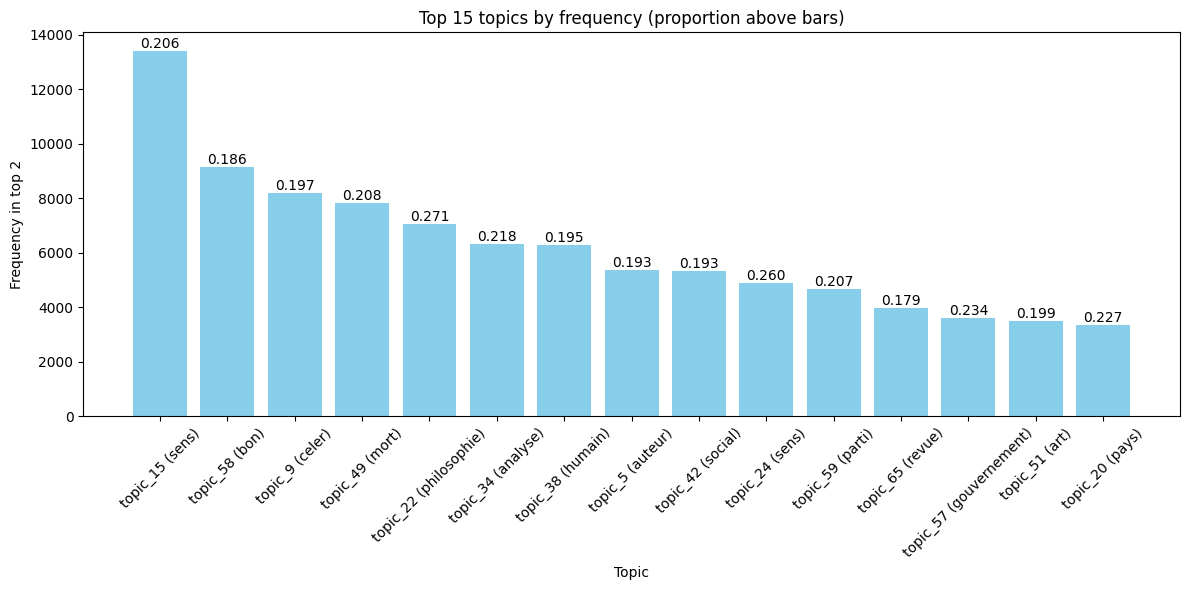

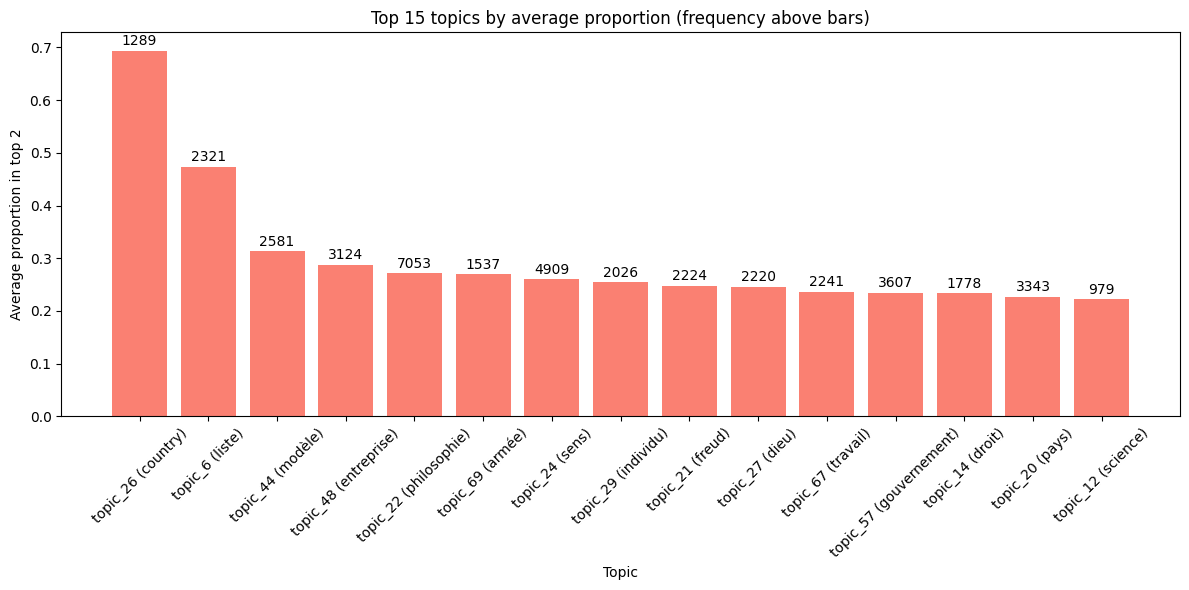

In [24]:
# ---------------------------------------------------------------------------
# Prepare data
# ---------------------------------------------------------------------------
# Flatten all topics in top 2 to count frequency
all_top2_topics = [topic for sublist in df_filtered["top_2_topics_with_prop"] for topic, _ in sublist]
topic_freq = Counter(all_top2_topics)

# Average proportion per topic
topic_props = defaultdict(list)
for top2 in df_filtered["top_2_topics_with_prop"]:
    for topic, prop in top2:
        topic_props[topic].append(prop)
avg_props = {topic: sum(props)/len(props) for topic, props in topic_props.items()}

# ---------------------------------------------------------------------------
# Plot 1: Top 15 topics by frequency
# ---------------------------------------------------------------------------
top_freq = topic_freq.most_common(15)
topics, counts = zip(*top_freq)
mean_props_top_freq = [avg_props[t] for t in topics]  # proportion to display

plt.figure(figsize=(12,6))
bars = plt.bar(range(len(topics)), counts, color="skyblue")
plt.xticks(range(len(topics)), topics, rotation=45)
plt.xlabel("Topic")
plt.ylabel("Frequency in top 2")
plt.title("Top 15 topics by frequency (proportion above bars)")

# Add mean proportion on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{mean_props_top_freq[i]:.3f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Plot 2: Top 15 topics by average proportion
# ---------------------------------------------------------------------------
top_avg = sorted(avg_props.items(), key=lambda x: x[1], reverse=True)[:15]
topics, mean_props = zip(*top_avg)
counts_top_avg = [topic_freq[t] for t in topics]  # occurrence to display

plt.figure(figsize=(12,6))
bars = plt.bar(range(len(topics)), mean_props, color="salmon")
plt.xticks(range(len(topics)), topics, rotation=45)
plt.xlabel("Topic")
plt.ylabel("Average proportion in top 2")
plt.title("Top 15 topics by average proportion (frequency above bars)")

# Add frequency on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{counts_top_avg[i]}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

#### 3.b 15 topics by average proportion and frequency in top 2

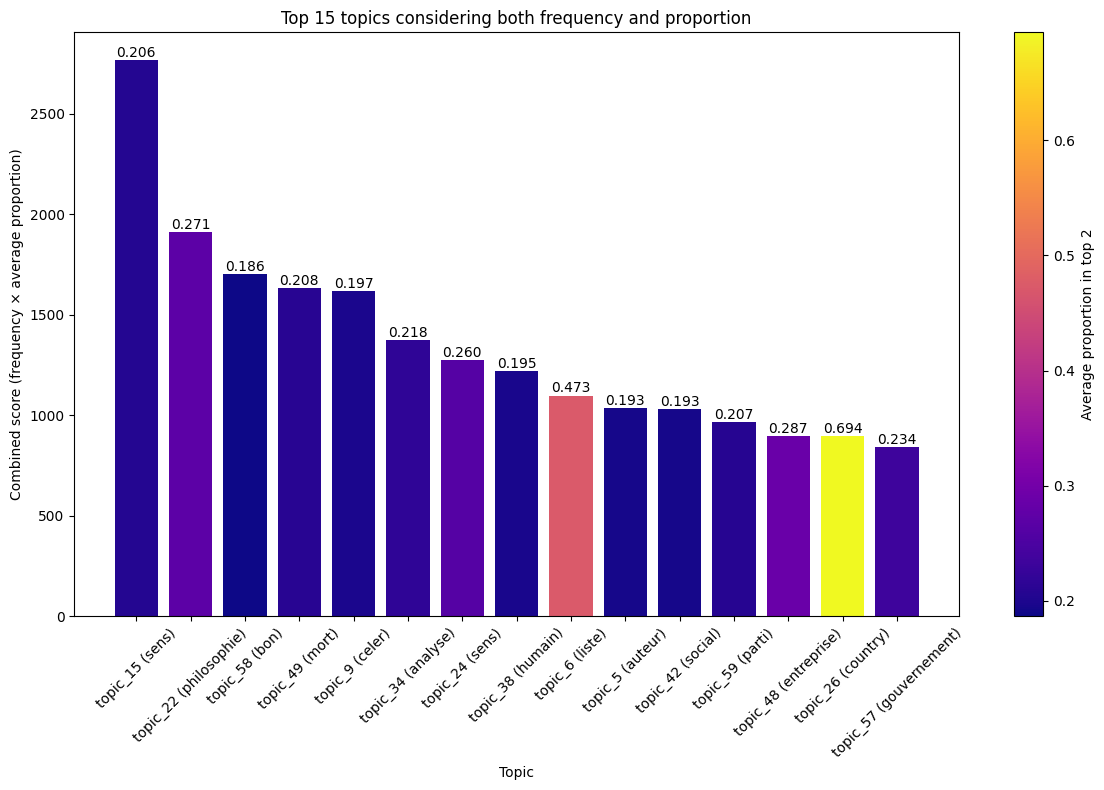

In [25]:
# ---------------------------------------------------------------------------
# Prepare data
# ---------------------------------------------------------------------------
all_top2_topics = [topic for sublist in df_filtered["top_2_topics_with_prop"] for topic, _ in sublist]
topic_freq = Counter(all_top2_topics)

topic_props = defaultdict(list)
for top2 in df_filtered["top_2_topics_with_prop"]:
    for topic, prop in top2:
        topic_props[topic].append(prop)
avg_props = {topic: sum(props)/len(props) for topic, props in topic_props.items()}

# Combined score: frequency * average proportion
combined_scores = {topic: topic_freq[topic] * avg_props[topic] for topic in topic_freq}

# Top 15 topics by combined score
top_combined = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:15]
topics, scores = zip(*top_combined)

# Color = average proportion
colors = np.array([avg_props[t] for t in topics])

# Normalize colors for better contrast
colors_norm = (colors - colors.min()) / (colors.max() - colors.min())

# ---------------------------------------------------------------------------
# Plot with colorbar
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(range(len(topics)), scores, color=plt.cm.plasma(colors_norm))
ax.set_xticks(range(len(topics)))
ax.set_xticklabels(topics, rotation=45)
ax.set_xlabel("Topic")
ax.set_ylabel("Combined score (frequency × average proportion)")
ax.set_title("Top 15 topics considering both frequency and proportion")

# Add average proportion on top of bars
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.5,
            f"{colors[i]:.3f}", ha='center', va='bottom', fontsize=10)

# Create colorbar
sm = plt.cm.ScalarMappable(cmap="plasma", norm=plt.Normalize(vmin=colors.min(), vmax=colors.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Average proportion in top 2")

plt.tight_layout()
plt.show()


#### 3.c Distribution of number of topics per article.

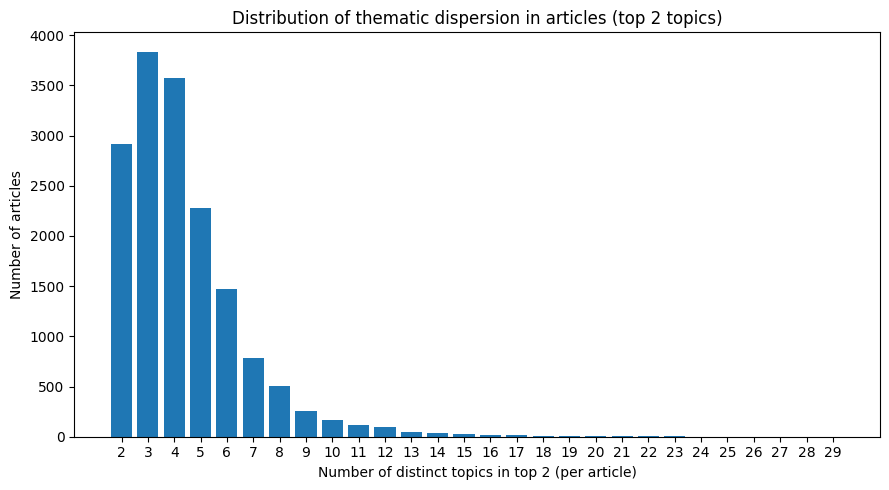

In [26]:
# ---------------------------------------------------------------------------
# Safely parse top_2_topics_with_prop (string → list of tuples if needed)
# ---------------------------------------------------------------------------
def safe_parse_top2(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

df_filtered["top_2_topics_with_prop"] = df_filtered["top_2_topics_with_prop"].apply(
    safe_parse_top2
)

# ---------------------------------------------------------------------------
# Compute number of distinct topics in top 2 per article (by URL)
# ---------------------------------------------------------------------------
topics_per_article = (
    df_filtered
    .groupby("url")["top_2_topics_with_prop"]
    .apply(
        lambda lists: len(
            {
                topic
                for sublist in lists
                for topic, _ in sublist
            }
        )
    )
)

# ---------------------------------------------------------------------------
# Discrete histogram
# ---------------------------------------------------------------------------
plt.figure(figsize=(9, 5))

plt.hist(
    topics_per_article,
    bins=range(
        topics_per_article.min(),
        topics_per_article.max() + 2
    ),
    align="left",
    rwidth=0.8
)

plt.xlabel("Number of distinct topics in top 2 (per article)")
plt.ylabel("Number of articles")
plt.title("Distribution of thematic dispersion in articles (top 2 topics)")
plt.xticks(
    range(
        topics_per_article.min(),
        topics_per_article.max() + 1
    )
)

plt.tight_layout()
plt.show()


#### 3.c Distribution of number of topics per author.

In [27]:
# Extraire toutes les valeurs uniques dans la colonne 'name', même si plusieurs par ligne
all_names = set()  # Utilisation d'un set pour éviter les doublons

for cell in df_filtered['name']:
    if pd.notna(cell):  # Ignorer les valeurs NaN
        names_in_cell = [name.strip() for name in cell.split('|')]
        all_names.update(names_in_cell)

# Convertir en liste triée pour lisibilité
unique_names = sorted(all_names)

# Affichage
print(unique_names)
print(f"Nombre de valeurs uniques : {len(unique_names)}")


['Alexandra Kollontaï', 'Alexandre Blok', 'Alexandre Guinzbourg', 'Alexandre Ostrovski', 'Alexandre Pouchkine', 'Alexandre Soljenitsyne', 'Alexandre Tvardovski', 'Alexandre Volkov', 'Alexandre Zinoviev', 'Alexis Tolstoï', 'Anatoli Martchenko', 'Andreï Kourkov', 'Anna Akhmatova', 'Antoine Volodine', 'Anton Tchekhov', 'Boris Akounine', 'Boris Kochno', 'Boris Pasternak', 'Boulat Okoudjava', 'Catherine II de Russie', 'Constantin Simonov', 'Evguénia Guinzbourg', 'Fiodor Dostoïevski', 'Galia Ackerman', 'Ilya Ehrenbourg', 'Isaac Babel', 'Ivan Bounine', 'Ivan Tourgueniev', 'Joseph Brodsky', 'Léon Tolstoï', 'Marina Tsvetaïeva', 'Maxime Gorki', 'Mikhaïl Boulgakov', 'Mikhaïl Zadornov', 'Nicolas Berdiaev', 'Nicolas Gogol', 'Nina Berberova', 'Ossip Mandelstam', 'Roman Jakobson', 'Svetlana Alexievitch', 'Varlam Chalamov', 'Vassili Axionov', 'Vassili Grossman', 'Vladimir Boukovski', 'Vladimir Maïakovski', 'Vladimir Nabokov', 'Vladimir Pozner', 'Vladimir Soloviev', 'Vladimir Sorokine', 'Youri Orlov']


In [28]:
author_topics = defaultdict(set)

for idx, row in df_filtered.iterrows():
    # Check if 'name' is not empty
    if row['name'] and row['top_2_topics_with_prop']:
        # Split multiple authors
        authors = [a.strip() for a in str(row['name']).split('|')]
        
        # If top_2_topics_with_prop is already a list of tuples, use it directly
        topics_list = row['top_2_topics_with_prop']
        
        for author in authors:
            for topic_id, _ in topics_list:
                author_topics[author].add(topic_id)

# Count distinct topics per author
topics_per_author = [len(topics) for topics in author_topics.values()]

# Convert to numpy array
topics_array = np.array(topics_per_author)

# Compute statistics
mean_topics = np.mean(topics_array)
median_topics = np.median(topics_array)
min_topics = np.min(topics_array)
max_topics = np.max(topics_array)
q25, q75 = np.percentile(topics_array, [25, 75])
count_above_15 = np.sum(topics_array > 15)

# Display results
print("Distribution of distinct topics (top 2) per unique author:")
print(f" Mean            : {mean_topics:.2f}")
print(f" Median          : {median_topics}")
print(f" Minimum         : {min_topics}")
print(f" Maximum         : {max_topics}")
print(f" 25th percentile : {q25}")
print(f" 75th percentile : {q75}")
print(f" Number >15 topics: {count_above_15}")
print(f" Number of unique authors: {len(author_topics)}")



Distribution of distinct topics (top 2) per unique author:
 Mean            : 58.30
 Median          : 61.0
 Minimum         : 14
 Maximum         : 70
 25th percentile : 53.25
 75th percentile : 67.75
 Number >15 topics: 49
 Number of unique authors: 50


#### 3.d Variations of topic distribution per author in time.

How to read the discrete time bands scatter plot:
Each horizontal line corresponds to a topic associated with the article the author is in. The x-axis represents the publication year, and each point on a line indicates that the topic appeared in the article that year. The size of each point is proportional to the average strength of the topic (mean_prop) in the texts: larger points indicate that the topic was more dominant, while smaller points indicate a weaker presence. This visualization allows you to see both which topics the author engaged with and how their prominence changed over time.

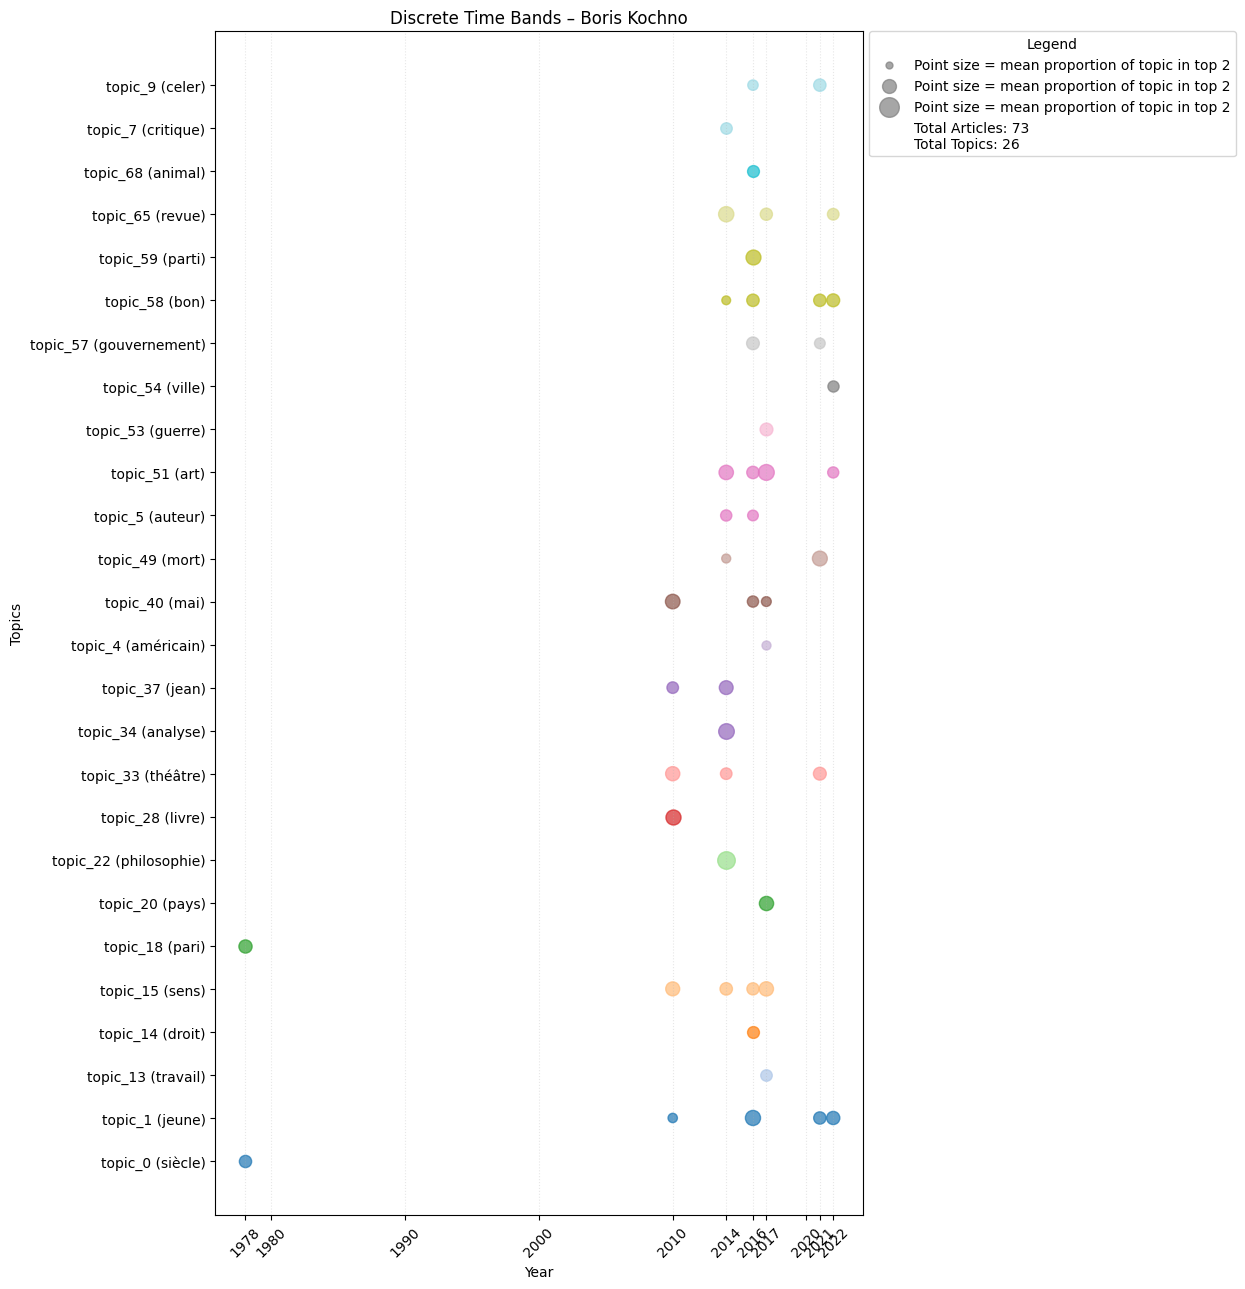

In [12]:
plt.figure(figsize=(14, height))  # largeur augmentée pour espacer les points

for i, topic in enumerate(topics_sorted):
    subset = df_agg[df_agg["topics"] == topic]
    if len(subset) == 0:
        continue
    plt.scatter(
        subset["annee"].to_numpy(),
        [i] * len(subset),
        s=(subset["mean_prop"].to_numpy() * 500),
        alpha=0.7,
        color=cmap(i)
    )

plt.yticks(range(len(topics_sorted)), topics_sorted)
plt.xlabel("Year")
plt.ylabel("Topics")
plt.title(f"Discrete Time Bands – {author}")

# X-axis ticks every year and every 10 years
years_points = df_agg["annee"].unique()
years_min, years_max = int(df_agg["annee"].min()), int(df_agg["annee"].max())
years_every10 = np.arange(years_min - years_min % 10, years_max + 1, 10)
years_ticks = sorted(set(years_points).union(years_every10))
plt.xticks(years_ticks, rotation=45)
plt.grid(axis="x", linestyle=":", alpha=0.3)

# Legend
total_articles = df_author.shape[0]
total_topics = len(topics_sorted)
size_legend = [0.05, 0.2, 0.4]

for size in size_legend:
    plt.scatter([], [], s=size*500, color='gray', alpha=0.7,
                label="Point size = mean proportion of topic in top 2")
plt.scatter([], [], s=0, color='white', label=f"Total Articles: {total_articles}\nTotal Topics: {total_topics}")

plt.legend(title="Legend", bbox_to_anchor=(1.01, 1), loc='upper left',
           borderaxespad=0, fontsize=10, frameon=True)

# Adjust layout: laisser plus de place au graphique
plt.tight_layout(rect=[0, 0, 0.90, 1])  # réduit la largeur pour la légende

plt.show()


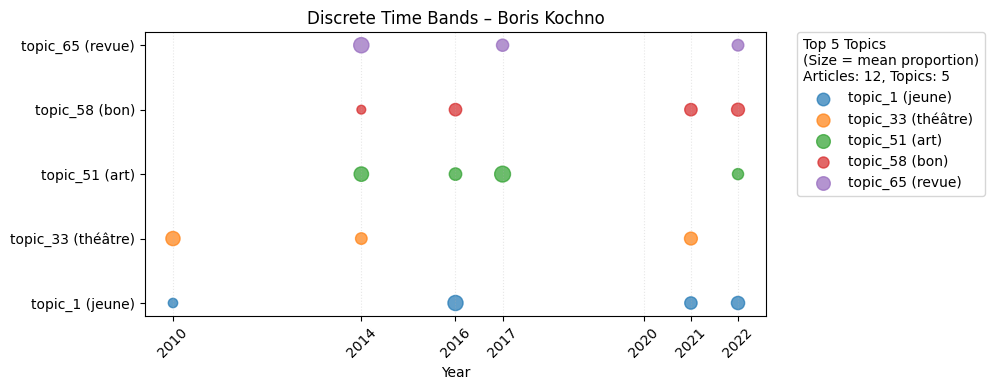

In [15]:
author = "Boris Kochno"

# ---------------------------------------------------------------------------
# Filter author
# ---------------------------------------------------------------------------
df_author = df_filtered[df_filtered["name"] == author].copy()

# ---------------------------------------------------------------------------
# Convert string → list of tuples if needed
# ---------------------------------------------------------------------------
if isinstance(df_author["top_2_topics_with_prop"].iloc[0], str):
    df_author["top_2_topics_with_prop"] = df_author["top_2_topics_with_prop"].apply(ast.literal_eval)

# ---------------------------------------------------------------------------
# Determine top 5 most frequent topics for this author
# ---------------------------------------------------------------------------
all_topics = [t[0] for sublist in df_author["top_2_topics_with_prop"] for t in sublist]
top5_topics = [t for t, _ in Counter(all_topics).most_common(5)]

# ---------------------------------------------------------------------------
# Create list of (topic, prop) pairs per row, only for top 5 topics
# ---------------------------------------------------------------------------
df_author["topic_prop"] = df_author["top_2_topics_with_prop"].apply(
    lambda x: [(t[0], t[1]) for t in x if t[0] in top5_topics]
)

# ---------------------------------------------------------------------------
# Explode the list of tuples
# ---------------------------------------------------------------------------
df_long = df_author.explode("topic_prop")

# Remove rows where topic_prop is NaN (i.e., article had no top5 topic)
df_long = df_long[df_long["topic_prop"].notna()]

# Split tuple into two separate columns
df_long["topics"] = df_long["topic_prop"].apply(lambda x: x[0])
df_long["props"]  = df_long["topic_prop"].apply(lambda x: x[1])

# ---------------------------------------------------------------------------
# Aggregate by year and topic
# ---------------------------------------------------------------------------
df_agg = df_long.groupby(["annee","topics"], as_index=False).agg(mean_prop=("props","mean"))

# ---------------------------------------------------------------------------
# Prepare plotting
# ---------------------------------------------------------------------------
topics_sorted = sorted(df_agg["topics"].unique())
height = max(0.5 * len(topics_sorted), 4)
plt.figure(figsize=(12, height))

# Colors for each topic
colors = plt.cm.tab10.colors  # up to 10 distinct colors
topic_color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(topics_sorted)}

# Plot points
for i, topic in enumerate(topics_sorted):
    subset = df_agg[df_agg["topics"] == topic]
    if len(subset) == 0:
        continue
    plt.scatter(
        subset["annee"].to_numpy(),
        [i] * len(subset),
        s=(subset["mean_prop"].to_numpy() * 500),  # point size proportional to mean prop
        alpha=0.7,
        color=topic_color_map[topic],
        label=topic
    )

# Y-axis: annotated topics
plt.yticks(range(len(topics_sorted)), topics_sorted)
plt.xlabel("Year")
plt.title(f"Discrete Time Bands – {author}")

# X-axis ticks (every year + every 10 years)
years_points = df_agg["annee"].unique()
years_min, years_max = int(df_agg["annee"].min()), int(df_agg["annee"].max())
years_every10 = np.arange(years_min - years_min % 10, years_max + 1, 10)
years_ticks = sorted(set(years_points).union(years_every10))
plt.xticks(years_ticks, rotation=45)

plt.grid(axis="x", linestyle=":", alpha=0.3)

# ---------------------------------------------------------------------------
# Legend: show point size meaning + number of articles and topics
# ---------------------------------------------------------------------------
articles_with_top5 = df_author[df_author["topic_prop"].apply(lambda x: len(x) > 0)]["url"].nunique()
total_topics = df_long["topics"].nunique()

plt.legend(
    title=f"Top 5 Topics\n(Size = mean proportion)\nArticles: {articles_with_top5}, Topics: {total_topics}",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=10
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave room for legend on the right
plt.show()

